# Simulating protocol 3, cell 5

In this notebook, I'll use Michaels method 3 parameters to simulate protocol 3 and get synthetic data similar to the real data for cell 5. 

To get an idea on how I compared the multiple parameter sets check the norebook called Kylie..._synth_parameterExplo_notebook...

All the data files are in my OneDrive at: /OneDrive .../Postdoc/cardiacNoiseData, but I'll add some of the data here in folder Some_Kilies_data/
There is a readme.txt file explaining what is in each file, including the names of the protocols and a dictionary of cell's names.  Protocols 3-5 are big files to have in github. Protocl 7 is the sine wave data, and protocol 6 is the action potential data. The protocols that I have the myokit version are 2, 3, 4, 5

- First load the data
- compare ODE solution and data
- check if the estimate for N matches the new parameters
- simulate synt data

In [21]:
# Libraries

import matplotlib.pyplot as plt
import numpy as np
import myokit
import myokit.lib.markov
from scipy.interpolate import interp1d

from scipy.optimize import minimize, minimize_scalar#, curve_fit
import cma
from sklearn.linear_model import LinearRegression

In [22]:
def SRexpo_spline(params, times, deltat, data, expo_4):
    expo_splines = params[0] + params[1]*np.exp(-(times-deltat)/params[2])+params[3]*np.exp(-(times-deltat)/params[4])
    if expo_4:
        expo_splines = expo_splines + params[5]*np.exp(-(times-deltat)/params[6]) + params[7]*np.exp(-(times-deltat)/params[8])
    
    residuals = expo_splines - data
    return sum(residuals**2)

def SRexpo_spline_weight(params, times, deltat, data, expo_4):
    expo_splines = params[0] + params[1]*np.exp(-(times-deltat)/params[2])+params[3]*np.exp(-(times-deltat)/params[4])
    if expo_4:
        expo_splines = expo_splines + params[5]*np.exp(-(times-deltat)/params[6]) + params[7]*np.exp(-(times-deltat)/params[8])
    #weight = np.exp(-(times-deltat)) / sum(np.exp(-(times-deltat)))
    weight =  1 / (1 + 9 * ((times - deltat)>10) + 90 * ((times - deltat)>100) +  900 * ((times - deltat)>1000))
    residuals = (expo_splines - data) 
    return sum((residuals**2) * weight)

def expo_spline(times, deltat, params, expo_4):
    # three_expo = flag to calculate 2 or 3 exponentials. Default == False. If true, we'll be fitting sum of 3 expo
    expo_splines = params[0] + params[1]*np.exp(-(times-deltat)/params[2])+params[3]*np.exp(-(times-deltat)/params[4])
    if expo_4:
        expo_splines = expo_splines + params[5]*np.exp(-(times-deltat)/params[6]) + params[7]*np.exp(-(times-deltat)/params[8])
    return expo_splines

def Quadratic_fit_for_N(N, x, data):
    quadratic_fit = x * (1 - x / N) 
    residuals = quadratic_fit - data
    return sum(residuals**2)

## Meta parameters

In [2]:
times_to_skip = 50 
NumExpo_flag = True # We will use 4 exponentials
saved_splines = False
saved_synthdata = True

N_lower = 10000
N_upper = 70000
FileNameNLower = 'protocol3_cell5_sim_pars_M_M1_N_lower_' + str(N_lower)
FileNameNUpper = 'protocol3_cell5_sim_pars_M_M1_N_upper_' + str(N_upper)

if saved_splines:
    print('This code will load the splines parameters instead of fitting them')

## Load the data and simulate it

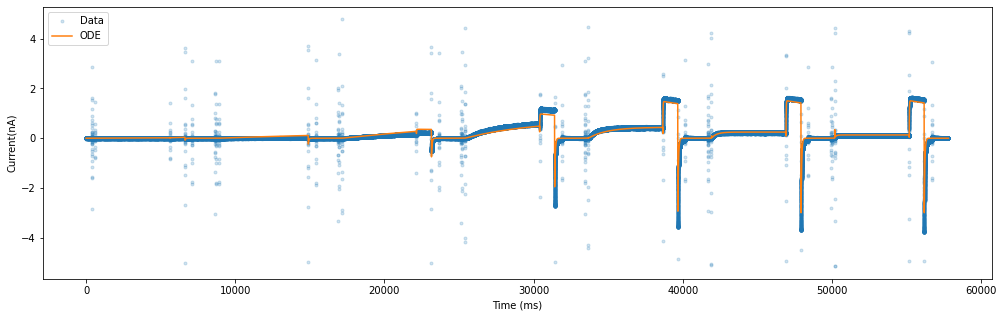

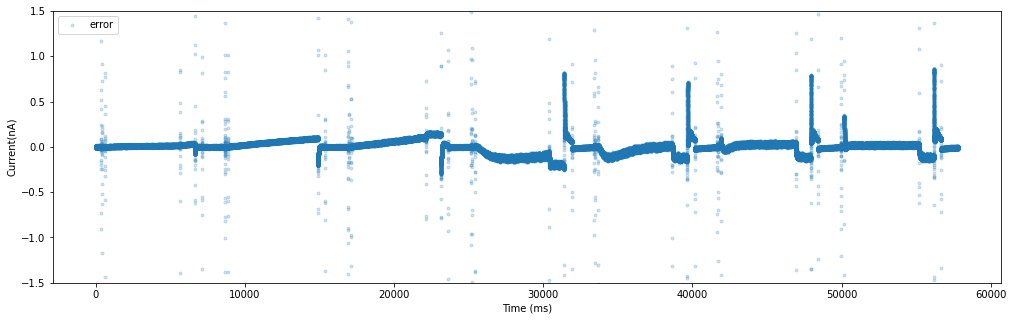

In [3]:
# Load the data
pr3_time, pr3_voltage, pr3_current = np.loadtxt('/Users/pmzah/OneDrive - The University of Nottingham/Postdoc/cardiacNoiseData/KyliePR3cellall.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)

# Load model
model = myokit.load_model('resources/beattie-2017-ikr-markov-M-M3.mmt')
# Load a protocols
protocol_3 = myokit.load_protocol('resources/pr3-steady-activation.mmt')
#protocol_5 = myokit.load_protocol('resources/pr5-deactivation.mmt')

# Create a parametrisable Hodgkin-Huxley model
parameters = [
    'ikr.p1', 
    'ikr.p2', 
    'ikr.p3', 
    'ikr.p4', 
    'ikr.p5', 
    'ikr.p6', 
    'ikr.p7', 
    'ikr.p8', 
    'ikr.p9',
]
markov_model = myokit.lib.markov.LinearModel.from_component(model.get('ikr'), parameters=parameters)
# Create an analytical simulation 
markov_sim_pr3 = myokit.lib.markov.AnalyticalSimulation(markov_model, protocol_3)
# Log times will be equal to the times from the data
hh_log_pr3 = markov_sim_pr3.run(pr3_time[-1] + 0.1, log_times=pr3_time)


plt.figure(figsize=(17, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current(nA)')
plt.plot(pr3_time, pr3_current, '.', alpha = 0.2,label='Data')
plt.plot(pr3_time, hh_log_pr3['ikr.IKr'], '-', label='ODE')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(17, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current(nA)')
plt.plot(pr3_time, hh_log_pr3['ikr.IKr']-pr3_current, '.', alpha = 0.2, label='error')
plt.legend(loc='upper left')
plt.ylim([-1.5,1.5])
plt.show()


## Stochastic simulation

For the parameters from Michael M3, the corresponding N is:

$$N = \frac{G_{kr}}{g_{kr}} = \frac{0.133898 \mu S}{2\text{ or } 13.5 pS}.$$
So, 
$$N_U = 66 949, \quad N_l = 9 918$$

I'll simulate:
$$N_U = 70000, \quad N_l = 10000$$ 

In [4]:
# Parameters
seed_m = 1
np.random.seed(seed_m)

if saved_synthdata:
    print('Loading synthetic data for N_upper = 70,000')
    I_grid_pr3_N_upper = np.load(FileNameNUpper + '_I_inter.npy' )
    O_grid_pr3_N_upper = np.load(FileNameNUpper + '_O_inter.npy' )
    print('DONE')
else:
# define the simulations and simualte
    sim_pr3_N_lower = myokit.lib.markov.DiscreteSimulation(markov_model, protocol_3, nchannels = N_lower)
    sim_pr3_N_upper = myokit.lib.markov.DiscreteSimulation(markov_model, protocol_3, nchannels = N_upper)
    print('Running simulation for N_l = ', N_lower)
    log_pr3_N_lower = sim_pr3_N_lower.run(pr3_time[-1] + 0.1)
    print('N_l DONE')
    print('Running simulation for N_U = ', N_upper)
    log_pr3_N_upper = sim_pr3_N_upper.run(pr3_time[-1] + 0.1)
    print('N_U DONE')
    # Save the opening and current track, and separated them into the same time steps as the data
    print('Interpolating for N_l')
    O_pr3_N_lower = np.array(log_pr3_N_lower['ikr.y3']) 
    I_pr3_N_lower = np.array(log_pr3_N_lower['ikr.IKr'])
    time_full_pr3_N_lower = np.array(log_pr3_N_lower['engine.time'])
    O_inter = interp1d(time_full_pr3_N_lower, O_pr3_N_lower,'previous', fill_value = "extrapolate")
    O_grid_pr3_N_lower = O_inter(pr3_time)
    I_inter = interp1d(time_full_pr3_N_lower, I_pr3_N_lower,'previous', fill_value = "extrapolate")
    I_grid_pr3_N_lower = I_inter(pr3_time)
    print('Interpolating for N_U')
    O_pr3_N_upper = np.array(log_pr3_N_upper ['ikr.y3']) 
    I_pr3_N_upper = np.array(log_pr3_N_upper['ikr.IKr'])
    time_full_pr3_N_upper = np.array(log_pr3_N_upper['engine.time'])
    O_inter = interp1d(time_full_pr3_N_upper, O_pr3_N_upper,'previous', fill_value = "extrapolate")
    O_grid_pr3_N_upper = O_inter(pr3_time)
    I_inter = interp1d(time_full_pr3_N_upper, I_pr3_N_upper,'previous', fill_value = "extrapolate")
    I_grid_pr3_N_upper = I_inter(pr3_time)
    print('Saving the simulation')
    np.save(FileNameNLower + '_I_inter.npy' ,I_grid_pr3_N_lower)
    np.save(FileNameNLower + '_O_inter.npy' ,O_grid_pr3_N_lower)
    np.save(FileNameNUpper + '_I_inter.npy' ,I_grid_pr3_N_upper)
    np.save(FileNameNUpper + '_O_inter.npy' ,O_grid_pr3_N_upper)
    print('DONE')



Loading synthetic data for N_upper = 70,000
DONE


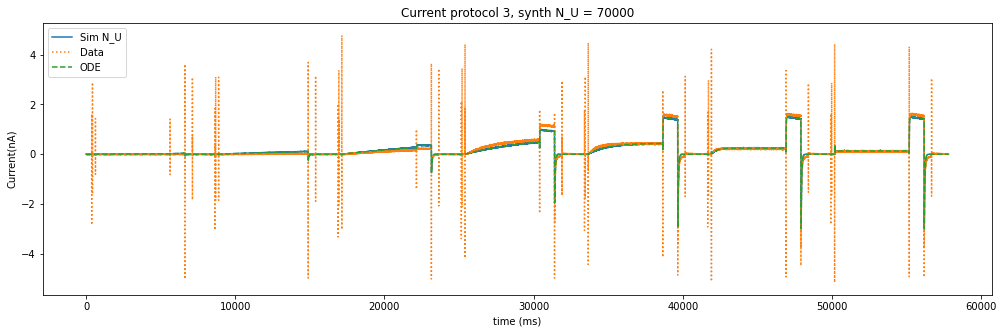

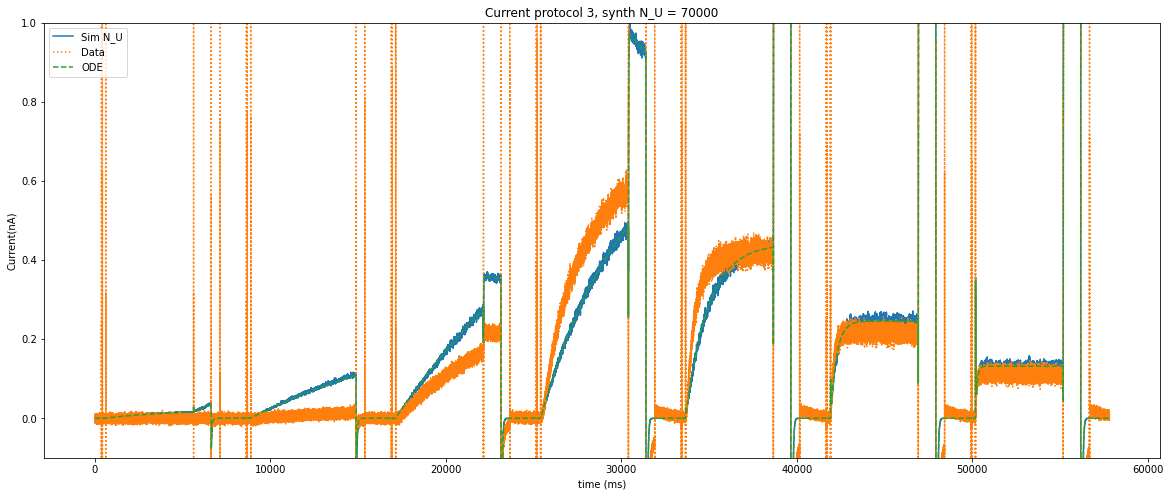

In [9]:
# Let's compare the simulation vs data 1.
plt.figure(figsize=(17, 5))
plt.plot(pr3_time, I_grid_pr3_N_upper ,'-', drawstyle='steps-post', label='Sim N_U')
plt.plot(pr3_time, pr3_current,':', drawstyle='steps-post', label='Data')
plt.plot(pr3_time, hh_log_pr3['ikr.IKr'],'--', drawstyle='steps-post', label='ODE')
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, synth N_U = ' + str(N_upper))
plt.legend(loc='upper left')

plt.show()

plt.figure(figsize=(20, 8))
plt.plot(pr3_time, I_grid_pr3_N_upper ,'-', drawstyle='steps-post', label='Sim N_U')
plt.plot(pr3_time, pr3_current,':', drawstyle='steps-post', label='Data')
plt.plot(pr3_time, hh_log_pr3['ikr.IKr'],'--', drawstyle='steps-post', label='ODE')
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, synth N_U = ' + str(N_upper))
plt.legend(loc='upper left')
plt.ylim(-.1, 1)

plt.show()

## Separate by voltage and define color scheme

In [18]:
# Define the steps of the protocol
pr3_Vtimes = (np.array(protocol_3.log_for_interval(0,pr3_time[-1] + 0.1)['time'])*10)
pr3_Vtimes = pr3_Vtimes.astype(np.int32)

pr3_current_constV = {}
pr3_current_constV_without_first5ms = {}
pr3_time_constV_without_first5ms = {}
I_grid_pr3_N_upper_constV = {}
I_grid_pr3_N_upper_constV_without_first5ms ={}
O_grid_pr3_N_upper_constV = {}
O_grid_pr3_N_upper_constV_without_first5ms ={}

for i in range(len(pr3_Vtimes)-1):
    pr3_current_constV[i]= pr3_current[pr3_Vtimes[i]:(pr3_Vtimes[i+1]-1)]
    pr3_current_constV_without_first5ms[i] = pr3_current[pr3_Vtimes[i] + times_to_skip:(pr3_Vtimes[i+1]-1)]
    pr3_time_constV_without_first5ms[i] = pr3_time[pr3_Vtimes[i] + times_to_skip:(pr3_Vtimes[i+1]-1)]
    I_grid_pr3_N_upper_constV[i] = I_grid_pr3_N_upper[pr3_Vtimes[i] :(pr3_Vtimes[i+1]-1)]
    O_grid_pr3_N_upper_constV[i] = O_grid_pr3_N_upper[pr3_Vtimes[i]:(pr3_Vtimes[i+1]-1)]
    I_grid_pr3_N_upper_constV_without_first5ms[i] = I_grid_pr3_N_upper[pr3_Vtimes[i] + times_to_skip:(pr3_Vtimes[i+1]-1)]
    O_grid_pr3_N_upper_constV_without_first5ms[i] = O_grid_pr3_N_upper[pr3_Vtimes[i] + times_to_skip:(pr3_Vtimes[i+1]-1)]
print(len(pr3_current_constV))

# Voltages
pr3_voltage_constV = pr3_voltage[pr3_Vtimes[:-1]]
pr3_unique_Vs, pr3_unique_Vs_1stUindex, pr3_unique_Vs_index= np.unique(pr3_voltage_constV, return_index = True, return_inverse = True)

# Colors & labels long
pr3_unique_Vs_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
pr3_voltage_constV_colors = []
pr3_voltage_constV_labels_full = []
for i in range(len(pr3_unique_Vs_index)):
    pr3_voltage_constV_colors.append(pr3_unique_Vs_colors[pr3_unique_Vs_index[i]])
    pr3_voltage_constV_labels_full.append('V ='+str(pr3_unique_Vs[pr3_unique_Vs_index[i]]))

# Labels simple
pr3_voltage_constV_labels_simple = np.repeat('_nolegend_', len(pr3_unique_Vs_index))
for i in range(len(pr3_unique_Vs_1stUindex)):
    pr3_voltage_constV_labels_simple[pr3_unique_Vs_1stUindex[i]] = 'V ='+str(pr3_unique_Vs[i])

42


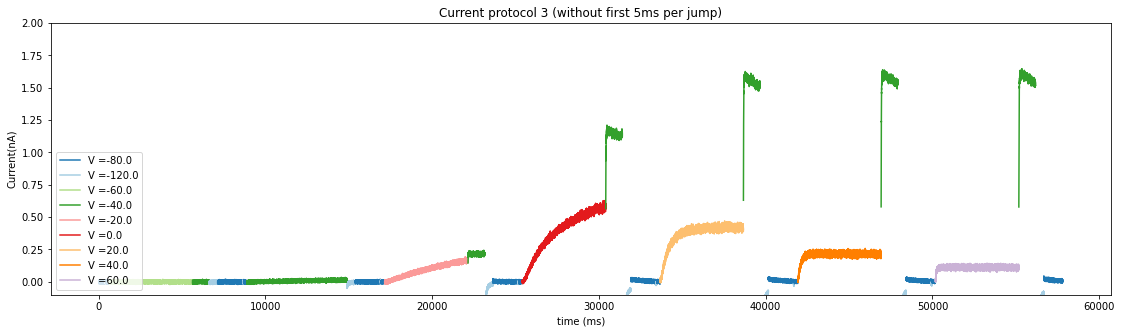

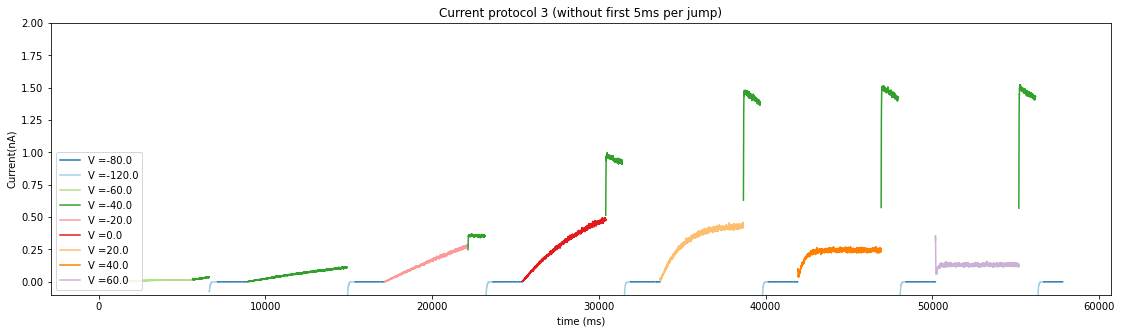

In [15]:
plt.figure(figsize=(19, 5))
#plt.plot(pr3_time,pr3_current,':', label = 'Full current')
for i in range(len(pr3_Vtimes)-1):
    plt.plot(pr3_time_constV_without_first5ms[i], pr3_current_constV_without_first5ms[i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('time (ms)')
plt.ylim([-.1,2])
plt.ylabel('Current(nA)')
plt.title('Current protocol 3 (without first 5ms per jump)')
plt.legend(loc='lower left')
plt.show()

plt.figure(figsize=(19, 5))
#plt.plot(pr3_time,pr3_current,':', label = 'Full current')
for i in range(len(pr3_Vtimes)-1):
    plt.plot(pr3_time_constV_without_first5ms[i], I_grid_pr3_N_upper_constV_without_first5ms[i],'-', color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.ylim([-.1,2])
plt.title('Current protocol 3 (without first 5ms per jump)')
plt.legend(loc='lower left')
plt.show()

## Separate the V >=40

In [16]:
print(pr3_voltage_constV[:-1]>=-40)

index_largerCurrents = np.nonzero(pr3_voltage_constV[:-1]>=-40)

index_largerCurrents = index_largerCurrents[0]
print(len(index_largerCurrents))

times_largerCurrents = [None] * len(index_largerCurrents)
I_grid_pr3_largerCurrents = [None] * len(index_largerCurrents)
I_grid_pr3_deltat_largerCurrents = np.zeros(len(index_largerCurrents))

I_grid_pr3_splines_largerCurrents = [None] * len(index_largerCurrents)
I_grid_pr3_splines_params_largerCurrents = [None] * len(index_largerCurrents)
I_grid_pr3_residuals2_largerCurrents = [None] * len(index_largerCurrents)

I_grid_pr3_splines_largerCurrents_weights = [None] * len(index_largerCurrents)
I_grid_pr3_splines_params_largerCurrents_weights= [None] * len(index_largerCurrents)
I_grid_pr3_residuals2_largerCurrents_weights = [None] * len(index_largerCurrents)

# Separate times and currents:

for index_i in range(len(index_largerCurrents)):
    i=index_largerCurrents[index_i]
    times_largerCurrents[index_i] = pr3_time_constV_without_first5ms[i]
    I_grid_pr3_largerCurrents[index_i] = I_grid_pr3_N_upper_constV_without_first5ms[i]
    I_grid_pr3_deltat_largerCurrents[index_i] =  times_largerCurrents[index_i][0]

[False False False False  True False False False False  True False False
 False False  True  True False False False False  True  True False False
 False False  True  True False False False False  True  True False False
 False False  True  True False]
12


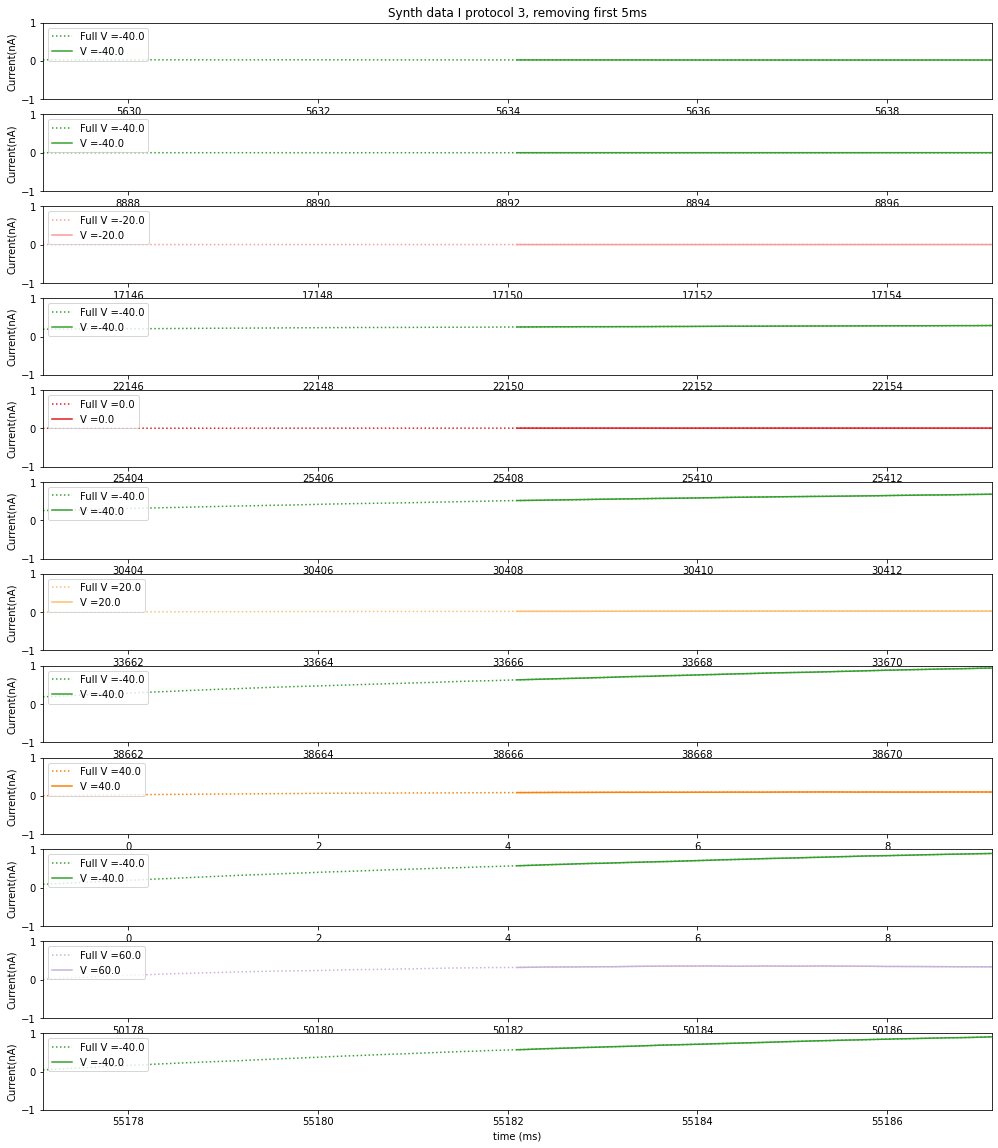

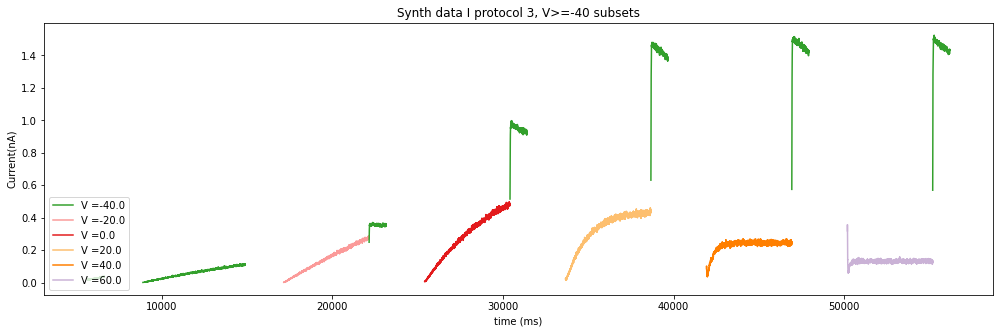

In [19]:

fig, axs = plt.subplots(len(index_largerCurrents),1, figsize=(17, 20))
axs = axs.ravel()
for index_i in range(len(index_largerCurrents)): 
    i=index_largerCurrents[index_i]
    axs[index_i].plot(pr3_time[(pr3_Vtimes[i]):(pr3_Vtimes[i+1]-1)], I_grid_pr3_N_upper_constV[i],':',color = pr3_voltage_constV_colors[i], label='Full ' + pr3_voltage_constV_labels_full[i])
    axs[index_i].plot(times_largerCurrents[index_i], I_grid_pr3_largerCurrents[index_i],'-',color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_full[i])
    axs[index_i].set_ylabel('Current(nA)')
    axs[index_i].legend(loc='upper left')
    axs[index_i].set_ylim([-1,1])
    axs[index_i].set_xlim([pr3_time[pr3_Vtimes[i]],pr3_time[pr3_Vtimes[i]]+10])
    if index_i == 0:
        axs[index_i].set_title('Synth data I protocol 3, removing first 5ms')
axs[index_i].set_xlabel('time (ms)')
plt.show()



plt.figure(figsize=(17, 5))
#plt.plot(pr3_time, pr3_current,':', label='Full protocol')
for index_i in range(len(index_largerCurrents)): 
    i=index_largerCurrents[index_i]
    plt.plot(times_largerCurrents[index_i], I_grid_pr3_largerCurrents[index_i],'-',color = pr3_voltage_constV_colors[i], label=pr3_voltage_constV_labels_simple[i])
    plt.xlabel('time (ms)')
    plt.ylabel('Current(nA)')
    plt.title('Synth data I protocol 3, V>=-40 subsets')
    plt.legend(loc='lower left')
plt.show()

In [23]:
# Find or load the splines parameters. NO WEIGHTS
if saved_splines:
    # Load the parameters of the spline:
    I_grid_pr3_splines_params_largerCurrents_weights = np.load(FileNameNUpper + '_I_inter_par_splinesWeights.npy')
    for index_i in range(len(index_largerCurrents)): 
        I_grid_pr3_splines_largerCurrents[index_i] = expo_spline(times_largerCurrents[index_i], I_grid_pr3_deltat_largerCurrents[index_i], I_grid_pr3_splines_params_largerCurrents_weights[index_i], NumExpo_flag)
    print('Loading with weights DONE')
else:
    # CMA fit weights
    for index_i in range(len(index_largerCurrents)): 
        i=index_largerCurrents[index_i]
        #Inital conditions and constrains:
        if NumExpo_flag:
            p0 = [I_grid_pr3_largerCurrents[index_i][-1], 0.01,times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0], 0.01,(times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0]), 0.01, (times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0])/2, 0.1,1]
            bounds_cma = [[None, None, 0, None, 0, None, 0,None, 0], [None, None, None, None, None, None, None,None,None]]
        else:
            p0 = [I_grid_pr3_largerCurrents[index_i][-1],I_grid_pr3_largerCurrents[index_i][-1] ,times_largerCurrents[index_i][-1] - times_largerCurrents[index_i][0] ,0.01 , times_largerCurrents[index_i][-1] - times_largerCurrents[index_i][0]]
            bounds_cma = [[0, 0, 0, 0, 0], [None, None, None, None, None]]
        optscma = cma.CMAOptions()
        optscma.set("bounds", bounds_cma)
        # CMA fit
        es = cma.fmin(SRexpo_spline_weight, p0 , sigma0=1, args=[times_largerCurrents[index_i], I_grid_pr3_deltat_largerCurrents[index_i], I_grid_pr3_largerCurrents[index_i], NumExpo_flag], options = optscma)
        I_grid_pr3_splines_params_largerCurrents_weights[index_i] = es[0]
        I_grid_pr3_splines_largerCurrents_weights[index_i] = expo_spline(times_largerCurrents[index_i], I_grid_pr3_deltat_largerCurrents[index_i], I_grid_pr3_splines_params_largerCurrents_weights[index_i], NumExpo_flag)
    # SAVE THE PARAMETERS
    np.save(FileNameNUpper + '_I_inter_par_splinesWeights.npy',np.array(I_grid_pr3_splines_params_largerCurrents_weights))
    print('Fitting with weights DONE')

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=818677, Sun Oct 31 19:48:21 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 2.004685850834961e+01 1.0e+00 9.83e-01  1e+00  1e+00 0:00.0
    2     20 2.816455261280427e+01 1.2e+00 9.12e-01  9e-01  1e+00 0:00.0
    3     30 4.419926093644113e-01 1.3e+00 8.73e-01  8e-01  9e-01 0:00.1
  100   1000 8.529686519504617e-04 9.7e+01 2.26e-02  4e-03  4e-02 0:01.6
  200   2000 2.485496982739542e-04 1.6e+03 3.86e-03  8e-05  7e-03 0:03.0
